# Data Science For Good: Small Enough to Fund


---
Songyu Yan, Mengtian Li


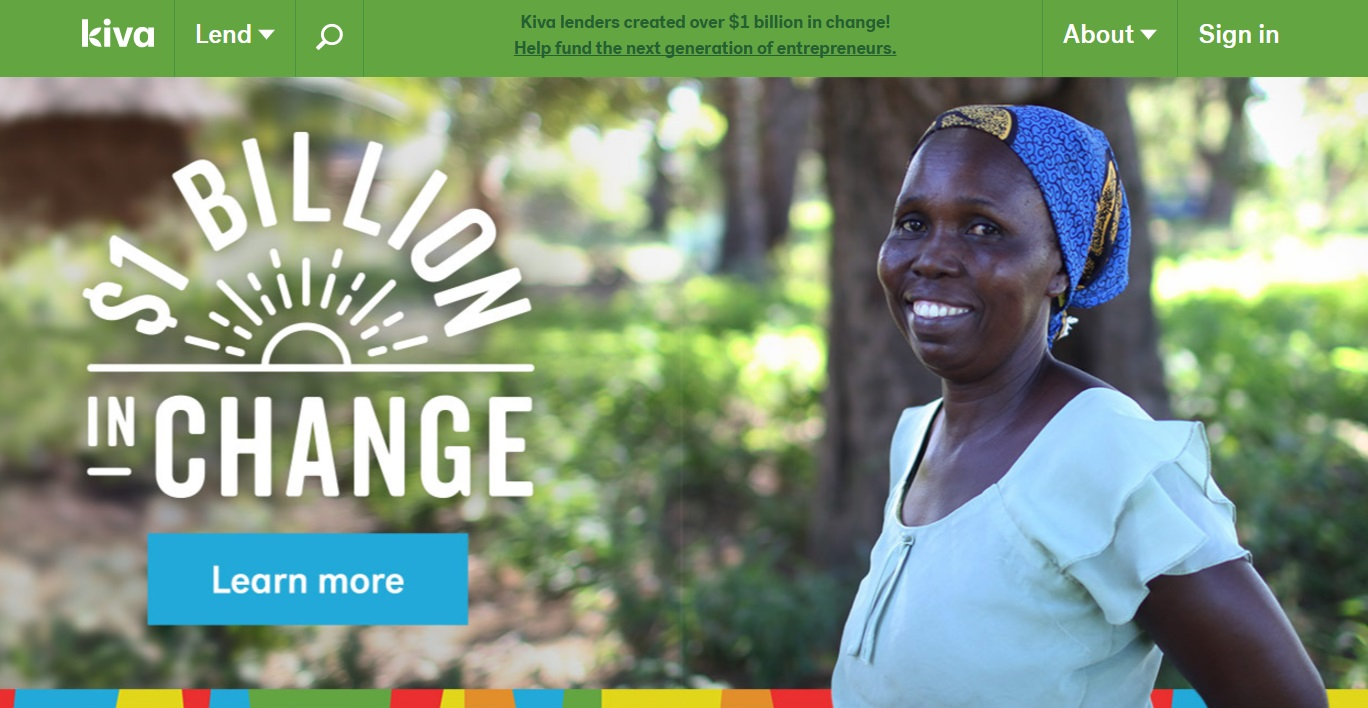

## Table of Content
-   <a href='#1'>Import Packages</a>
-   <a href='#2'>Data Loading and Importation</a>
  - <a href='#21'>Data Loading</a>
  - <a href='#22'>Data Importation</a>
  - <a href='#23'>Generate Labels</a>
- <a href='#3'>Exploratory Data Analysis</a>
  - <a href='#31'>Loan Amount</a>
  - <a href='#32'>Loan Activities</a>
  - <a href='#33'>Loan Sectors</a>
  - <a href='#34'>Time Relevant Data</a>
  - <a href='#35'>Borrower Gender</a>
  - <a href='#36'>Repayment Interval Count</a>
- <a href='#4'>Wordcloud and Natural Language Pre-processing</a>
- <a href='#5'>Geographic Data Visualization</a>
- <a href='#6'>Combine MPI data with Loang Requests</a>
  - <a href='#61'>Data Cleaning</a>
  - <a href='#62'>Join Tables</a>
- <a href='#7'> Data Pre-Processing
  - <a href='#71'>Drop Columns</a>
  - <a href='#72'>Fill Missing Values</a>
- <a href='#8'>Modeling</a>
  - <a href='#81'>Encoding</a>
  - <a href='#82'>Train-Test Split</a>
  - <a href='#83'>Model Training and Tuning</a>
    - <a href='#831'>XGB Boost</a>
    - <a href='#832'>AutoML</a>
  - <a href='#84'>Modeling Discussion</a>
- <a href='#9'>Conclusion</a>



Kiva is a non-profit organization that provides financial services to poor and financially excluded people around the world. It establishes a bilateral relationship between individual lenders and borrowers with 0 interest rate. Through Kiva's work, students can pay for tuition, women can start businesses, farmers are able to invest in equipment and families can afford needed emergency care.

The dataset we collected contains loans issued in 2016-2018. Via our analysis, we would like to develop a predictive model to assess if a loan requested will be funded. Our results shall benefit both lenders and borrowers. For prospective borrowers, given their demographic data and business nature, our model suggests if Kiva is an optimal platform for them to obtain financial support. As the platform aborts projects with insufficient funding, foreseeing if their invested projects will be delivered shall guide lenders to wisely allocate their investment.

We are going to use XGBoost and AutoML machine learning methods to build our model and analyze on how lenders choose to fund a particular loan request in addition to predicting whether a loan request will be funded.

## <a id="1">Import Packages</a>


In [ ]:
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn==0.10.0

In [ ]:
!python -m nltk.downloader 'punkt'
!python -m nltk.downloader 'averaged_perceptron_tagger'
!python -m nltk.downloader 'universal_tagset'
!pip install wordcloud

In [ ]:
!pip install category_encoders

In [ ]:
# Package Import

# Data Wrangling
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from scipy.sparse import csr_matrix

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px

# Modeling
from xgboost import XGBClassifier
import xgboost as xgb
import autosklearn.classification
import autosklearn.metrics
from category_encoders import TargetEncoder
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, fbeta_score, make_scorer, f1_score, jaccard_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix



# sampling
from sklearn.model_selection import train_test_split

# Globals
RANDOM_STATE = 545

import warnings
warnings.simplefilter("ignore")

## <a id="2">Data Loading and Importation </a>


### <a id="21">Data Loading </a>
We pulled raw data directly from Kaggle, and stored the unzipped data within ./Files/ .

In [ ]:
!mkdir /root/.kaggle/
!touch /root/.kaggle/
!touch ~/.kaggle/kaggle.json

api_token = {"username":"songyuyve","key":"7506c9f82e3f6041a8046dd646ec6ec9"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kiva/data-science-for-good-kiva-crowdfunding

In [ ]:
!unzip data-science-for-good-kiva-crowdfunding.zip 

### <a id="22">Data Importation</a>

We collected 2 .csv files from Kaggle, and separately stored each table within a pandas DataFrame. 

We also collected another .csv file from 
Oxford Poverty & Human Development Initiative (OPHI). It contains MPI per nation from [OPHI](Ihttps://ophi.org.uk/wp-content/uploads/Table-1-National-Results-MPI-2020_vs2.xlsx). The global Multidimensional Poverty Index (MPI) is an international measure of acute multidimensional poverty covering over 100 developing countries. It complements traditional monetary poverty measures by capturing the acute deprivations in health, education, and living standards that a person faces simultaneously. It has been shown in previous studies that MPI has high correlation with where the funds are directed to. So we want to include MPI in our prediction model. The .csv file was manually cleaned.

|Table Name|Number of Records|Number of Features|
|----|----|----|
|loan_raw| 671204|20|
|mpi_region|2772 | 9|
|mpi_national| 107 | 4 |

In [ ]:
loan_raw = pd.read_csv('kiva_loans.csv')
mpi_region = pd.read_csv('kiva_mpi_region_locations.csv')
mpi_national = pd.read_csv('MPI_national.csv')

In [ ]:
loan_raw.head(3)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01


In [ ]:
mpi_region.head(3)

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754


In [ ]:
mpi_national.drop(mpi_national.columns[[4,5,6,7]],axis=1,inplace=True)
mpi_national.drop_duplicates(inplace=True)
mpi_national.head(3)

,ISO,country,world_region,MPI
0,ARM,Armenia,Europe and Central Asia,0.001
1,UKR,Ukraine,Europe and Central Asia,0.001
2,GEO,Georgia,Europe and Central Asia,0.001


### <a id="23">Generate Labels</a>

As the ultimate goal of our project is to train a model determining if a loan request can be founded, we added a predictor column within **loan_raw** as *isfunded*. 

If a record's *funded_amount* equals *loan_amount*, then it can be assumed as being funded, labeled as 1, 0 otherwise.


In [ ]:
# Add target variable, isFunded
loan_raw['isfunded'] = (loan_raw.funded_amount>=loan_raw.loan_amount).astype(int)

In [ ]:
# Total percent of funded loans
loan_raw.isfunded.sum()/len(loan_raw)

0.9279981525763366

## <a id="3">Exploratory Data Analysis </a>
Our primary table will be **loan_raw**, which contains detailed information regarding transaction amount, time and origins. The other three tables contain supplementary information regarding a borrower country's economic status and  transaction agency.

We will start the exploratory analysis from **loan_raw** table, containing 671204 records and 20 columns.

| Column Name | Interpretation | Note |
| ----------- | --------------- | ----- |
| Id  | Unique ID for loan |
 | funded_amount |The amount disbursed by Kiva to the field agent(USD) |
| loan_amount |The amount disbursed by the field agent to the borrower(USD) |
|activity | More granular category | Text format
| sector |High level category | Text format
| use | Exact usage of loan amount | Text format
| country_code| country code of country in which loan was disbursed |
| country |Full country name of country in which loan was disbursed |
| region | Full region name within the country |
| currency |The currency in which the loan was disbursed |
| partner_id | ID of partner organization| local field finance partner who helps file application
| posted_time | The time at which the loan is posted on Kiva by the field agent | YYYY-mm-dd HH-MM-SS
disbursed_time | The time at which the loan is disbursed by the field agent to the borrower | YYYY-mm-dd HH-MM-SS
funded_time | The time at which the loan posted to Kiva gets funded by lenders completely | YYYY-mm-dd HH-MM-SS
| term_in_months | The duration for which the loan was disbursed in months | 
| lender_count |The total number of lenders that contributed to this loan |
| tags |  |
| borrower_genders |Comma separated M,F letters, where each instance represents a single male/female in the group |
| repayment_interval | | 'monthly', 'weekly', 'irregular', 'bullet'
| date | | YYYY-mm-dd


### <a id="31">Loan Amount</a>

Based on data description, all transaction amounts are measured in USD. 

In [ ]:
loan_raw[['funded_amount','loan_amount']].describe()

,funded_amount,loan_amount
count,671205.000000,671205.000000
mean,785.995061,842.397107
std,1130.398941,1198.660073
min,0.000000,25.000000
25%,250.000000,275.000000
50%,450.000000,500.000000
75%,900.000000,1000.000000
max,100000.000000,100000.000000


From statistics above, we can observe that both columns have a wide range of transaction amount. Both columns have centralized data within a lower range, and some large-amount transactions as outliers. This leads to high variance within both columns.

Despite the means and variances are close, there is a slight difference between quantiles of *funded_amount* and *loan_amount*. This is reasonable as not all requested loans are funded.

Text(0.5, 1.0, 'Funded Amount Distribution')

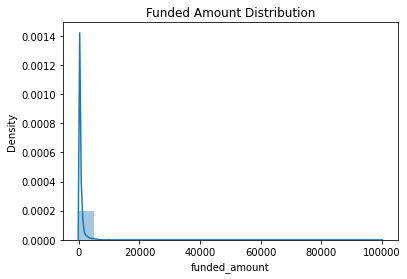

In [ ]:
sns.distplot(loan_raw.funded_amount, bins=20)
plt.title('Funded Amount Distribution')

As the *funded_amount* is highly left skewed. We used log transformation to normalize the data before visualization. We removed 0 amount transactions to avoid log(0).

Text(0.5, 1.0, 'Log-transformed Funded Amount Distribution')

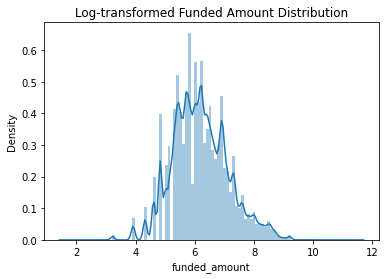

In [ ]:
sns.distplot(np.log(loan_raw[loan_raw.funded_amount>0].funded_amount), bins=100)
plt.title('Log-transformed Funded Amount Distribution')

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Text(0.5, 1.0, 'Log-transformed Loan Amount')

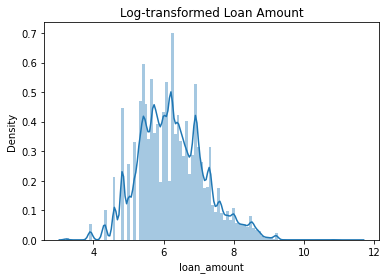

In [ ]:
sns.distplot(np.log(loan_raw.loan_amount+0.001), bins=100)
plt.title('Log-transformed Loan Amount')

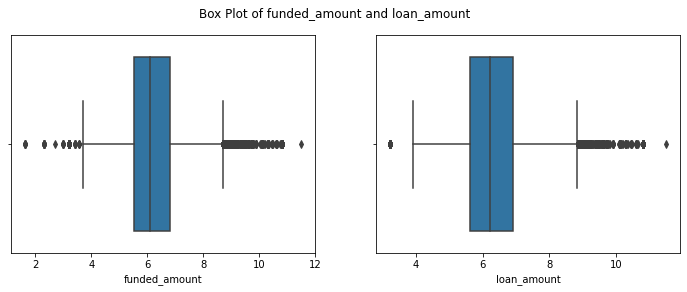

In [ ]:
# Side-by-side box plot of funded_amount and loan_amount
fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.suptitle('Box Plot of funded_amount and loan_amount')
# Removed outlier 0 for a more explicit comparison
fig1 = sns.boxplot(np.log(loan_raw[loan_raw['funded_amount'] > 1].funded_amount+0.001), ax=ax[0])
fig2 = sns.boxplot(np.log(loan_raw.loan_amount+0.001), ax=ax[1] )

Observations from distribution plots above:

* Both columns have centralized loan amount within the lower range (75% quantile), and large amount outliers.
* *loan_amount* has a slightly larger medium and a wider range of transaction amount.



### <a id="32">Loan Activities</a>

In [ ]:
loan_raw.activity.nunique()

163

In [ ]:
loan_raw.activity.value_counts()/len(loan_raw)

Farming                      0.108693
General Store                0.096437
Personal Housing Expenses    0.048343
Food Production/Sales        0.041874
Agriculture                  0.040260
                               ...   
Film                         0.000019
Personal Care Products       0.000010
Celebrations                 0.000007
Event Planning               0.000007
Adult Care                   0.000003
Name: activity, Length: 163, dtype: float64

Out of 163 categories, Farming and General Store are the top 2 categories for loans.

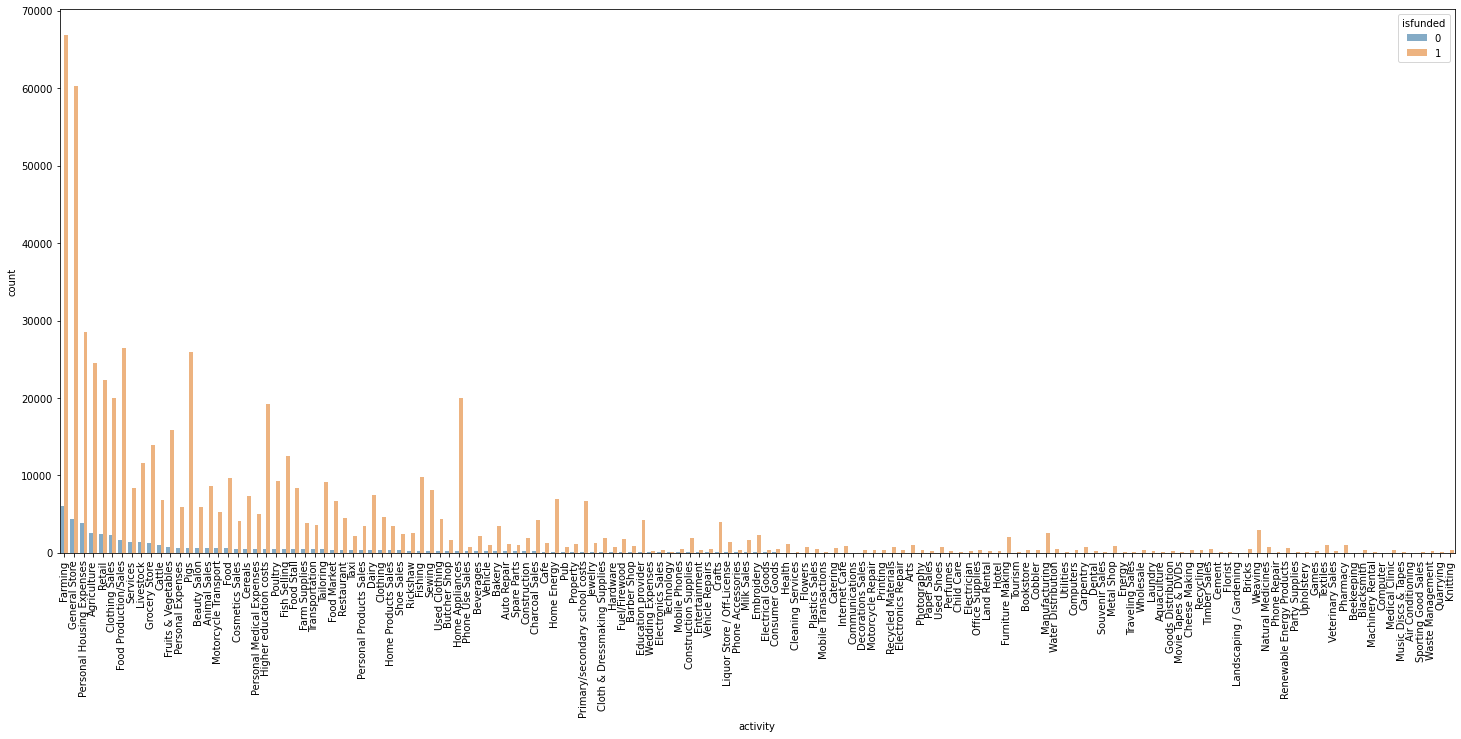

In [ ]:
# Funded by activity
plt.figure(figsize=(25,10))
plt.xticks(rotation=90)
g = sns.countplot(x='activity', hue='isfunded', data=loan_raw, 
              order=loan_raw[loan_raw['isfunded']==0].activity.value_counts().index, alpha=0.6)

The graph above is sorted by number of unfunded requests in descending order. Activities like Food Product/Sales, Pigs, Higher Education Cost and Home Appliances have a higher amount of unfunded requests.

### <a id="33">Loan Sectors</a>

In [ ]:
loan_raw.sector.nunique()

15

Text(0.5, 1.0, 'Funded Vs Not-funded by Sector')

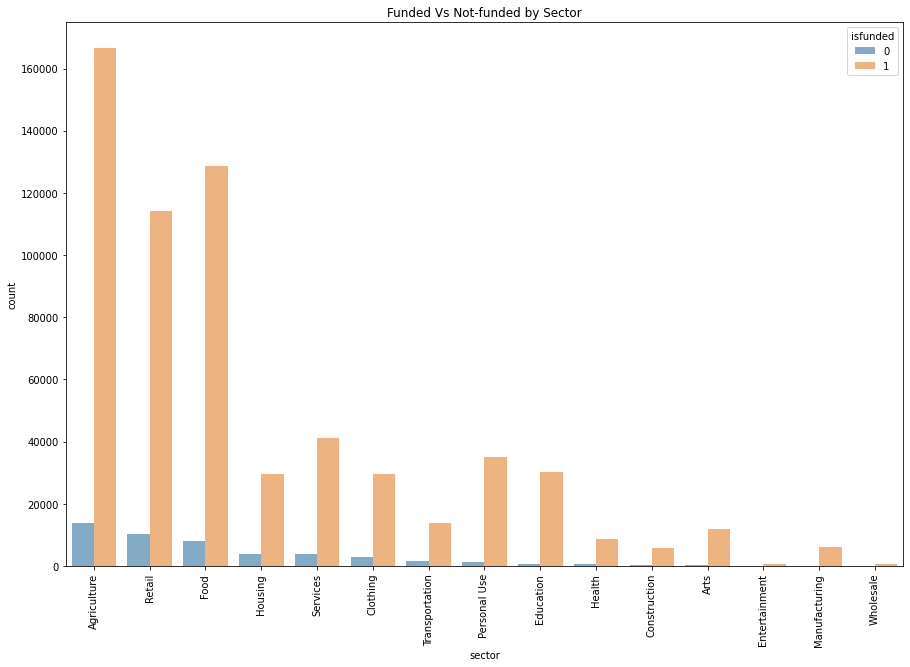

In [ ]:
# Funded by sectors
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
g = sns.countplot(x='sector', hue='isfunded', data=loan_raw, 
              order=loan_raw[loan_raw['isfunded']==0].sector.value_counts().index, alpha=0.6)
plt.title('Funded Vs Not-funded by Sector')

Similar with *activity* visualization, the columns in the graph above are listed by the number of not funded transactions in descending order. Secotrs like Food, Services, Personal Use has a higher portion of unfunded loans compared with the others.

### <a id="34">Time Relevant Data</a>

We started from transforming string typed data to pandas timestamp.

In [ ]:
# Handle time relevant data
loan_raw[['disbursed_time','funded_time','posted_time']] = loan_raw[['disbursed_time','funded_time','posted_time']].apply(pd.to_datetime)

According to Kiva, after a loan is posted, it will not be removed from display until funded or reaches a 30-day expiration date. **Thus, the time column with exact request, disburse and funded time and date does not provide significant insights in modeling.**

In [ ]:
loan_raw['disbursed_int'] = (loan_raw.disbursed_time-loan_raw.posted_time).dt.days
loan_raw['funded_int']=(loan_raw.funded_time-loan_raw.posted_time).dt.days

Text(0.5, 1.0, 'Amount of days taken to disburse fund to borrowers')

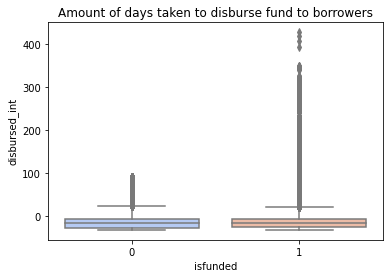

In [ ]:
sns.boxplot(y='disbursed_int',x='isfunded',data=loan_raw, palette='coolwarm')
plt.title('Amount of days taken to disburse fund to borrowers')
# outlier, expiration term

In [ ]:
loan_raw.drop(loan_raw[loan_raw.funded_int < 0].index, inplace = True) 

Text(0.5, 1.0, 'Amount of days taken to reach funding goals')

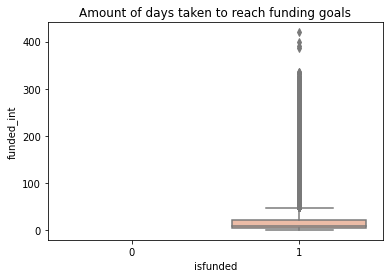

In [ ]:
sns.boxplot(y='funded_int',x='isfunded',data=loan_raw, palette='coolwarm')
plt.title('Amount of days taken to reach funding goals')

This makes sense given not funded loans does not have a fund date.

### <a id="35">Borrower Gender</a>

We observsed that *borrower_genders* are listed as 1-word string as either female or male. Instead, it is listed as a comma separated string, with each word represent the gender of individual borrowers. For example, the text below represents 2 female borower and 1 male borrower.


```
"female, male, female"
```
As text-formated cells do not support prospective model training, we performed following steps of feature engineer:


*   We split the comma separated string, counted the number of borrowers and stored this information in *borrower_count*
*   We used string and set operations to categorize borrowers into 3 groups. If all borrowers are of the same gender, they are labeled as 'female' or 'male'; if the groups is of mixed genders, they are labeled as 'group'. 



In [ ]:
# Notice that gender column have multiple words, represent number of borrower
def borrower_count(row):
  if isinstance(row,str):
    return len(row.split(','))
  return -1

In [ ]:
loan_raw['borrower_num']=loan_raw.borrower_genders.apply(borrower_count)

Text(0.5, 1.0, 'Number of Borrowers Distribution Plot')

<Figure size 720x1080 with 0 Axes>

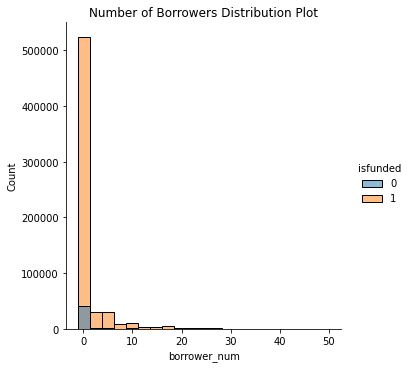

In [ ]:
plt.figure(figsize=(10,15))
sns.displot(x='borrower_num',hue='isfunded',data=loan_raw)
plt.title('Number of Borrowers Distribution Plot')

In [ ]:
loan_raw.borrower_num.value_counts()[:10]/len(loan_raw)

 1     0.836126
 2     0.024154
 3     0.024136
 4     0.020183
 5     0.020094
 8     0.008091
 10    0.007700
 6     0.007422
-1     0.006289
 7     0.006019
Name: borrower_num, dtype: float64

More than 90% loans are requested by less than 5 borrowers. 

In [ ]:
# If mixed-gender participants, mark as group
def gender_group(row):
  if isinstance(row, str):
    if len(set(row.split(',')))>1:
      return 'group'
    return row.split(',')[0]
  return row

loan_raw['borrower_genders'] = loan_raw['borrower_genders'].apply(gender_group)

In [ ]:
loan_raw['borrower_genders'].unique()

array(['female', 'group', 'male', nan], dtype=object)

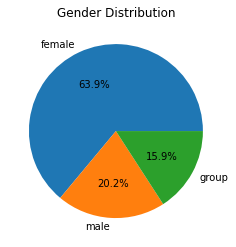

In [ ]:
borrowers = loan_raw['borrower_genders'].value_counts()
plt.pie(borrowers, autopct="%.1f%%", labels=borrowers.keys())
plt.title('Gender Distribution')
plt.show()

From visualization above, out of all requests with given gender, 63.9% are requested solely by female borrowers, 20.2% by male, 15.9% by mixed gender groups.

### <a id="36">Repayment Interval Count</a>

Text(0.5, 1.0, 'Repayment Interval Count')

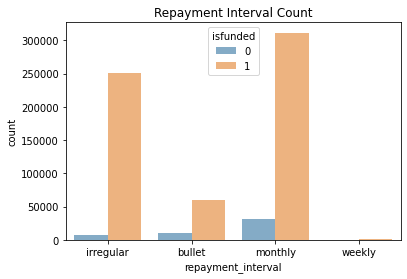

In [ ]:
sns.countplot(x='repayment_interval', hue='isfunded',data=loan_raw, alpha=0.6)
plt.title('Repayment Interval Count')

According to data description, 'bullet' represents payments with a lump sum payment made for the entirety of an outstanding loan amount, usually at maturity.

Based on visualization above, monthly paid loans have a higher proportion of not funded requests.

## <a id="4">Natural Language Preprocessing</a>

The *use* column contains a text description of the reason for requested loan. To prepare data for modeling, we extracted **nouns** and **verbs** out of the texts. Wordcloud graphs help us visualize if there is any specific types of usage are most frequently listed on Kiva.

In [ ]:
loan_raw.use.apply(type).unique()

array([<class 'str'>, <class 'float'>], dtype=object)

Notice *use* does have missing values. We replicated this column and removed all missing values.

In [ ]:
usage = loan_raw.use.dropna()
usage.apply(type).unique()

array([<class 'str'>], dtype=object)

In [ ]:
def find_noun_verb(row):
  ''' Takes a useage string, tokenize it, and label words using nltk
  row: string-typed usage
  return: a tuple of list of nouns and actions
  '''
  use_set = nltk.word_tokenize(row)
  tagged = nltk.pos_tag(use_set, tagset='universal')
  nouns = " ".join([word[0] for word in tagged if word[1] == 'NOUN'])
  actions = " ".join([word[0] for word in tagged if word[1] == 'VERB'])
  return nouns,actions

In [ ]:
usage_noun, usage_how = zip(*usage.apply(find_noun_verb))

In [ ]:
# Transform tuple into list
usage_noun = list(usage_noun)

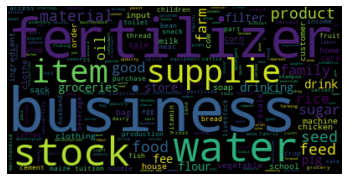

In [ ]:
wordcloud = WordCloud(collocations=False).generate(" ".join(usage_noun))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

'business', 'fertilizer', 'water', 'stock' are some of the most frequently listed purposes for loans.

As usage_noun is now a list of strings, each stringcontains nouns within *use* from 1 loan request. 


```
['okra tomato eggplant seeds herbicide',
 'box fish',
 'semester registration fees',
 'tomato pepper okra seeds herbicide',
 'bread drinks oils vegetables fruits candy soap shampoo', ...
```


To find the top 10 most frequently appearing nouns, we concatenated these strings, split the concatenated string and used dictionary manipulation to perform single word counts.

In [ ]:
# Concatenate strings
usage_noun_dic = Counter(usage_noun)
noun_str = ""
for k in usage_noun_dic:
  noun_str += (k+" ")*usage_noun_dic[k]

In [ ]:
# Split concatenated string by space, perform word count
noun_str_dic = Counter(noun_str.split(' '))

In [ ]:
usage_common_str = noun_str_dic.most_common(10)
usage_common_str

[('business', 65284),
 ('water', 49642),
 ('supplies', 40858),
 ('items', 38939),
 ('products', 35459),
 ('fertilizer', 34869),
 ('stock', 33559),
 ('materials', 32791),
 ('family', 31049),
 ('seeds', 30895)]

After arriving at the 10 most frequently appearing noun keywords, we added a *common_noun* column within **loan_raw** dataframe. If one of the 10 keyword exists within *use*, we label the record using the keyword with highest frequency. For example, if 'business' and 'water' show up within one record, it is labeled as 'business'. If the record contains none of these keywords, it is labeled as 'others'.

In [ ]:
# keep top 10 most frequent nouns, map into 11 classes
def map_noun(row):
  if isinstance(row,str):
    row_set = set(row.split())
    for i in range(10):
      if usage_common_str[i][0] in row_set:
        return usage_common_str[i][0]
  return 'others'
loan_raw['common_noun']=loan_raw.use.apply(map_noun)

In [ ]:
loan_raw.common_noun.value_counts()

others        449140
supplies       30667
items          29990
business       29250
water          27213
stock          26705
fertilizer     25408
materials      22342
products       15543
seeds          10142
family          4804
Name: common_noun, dtype: int64

We also used WordCloud to visualize usage of verbs.

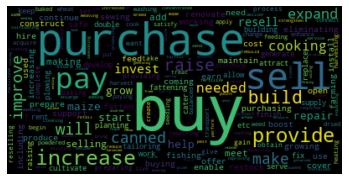

In [ ]:
usage_verb_dic = Counter(usage_how)
verb_str = ""
for k in usage_verb_dic:
  verb_str += (k+" ")*usage_verb_dic[k]
  
wordcloud = WordCloud(collocations=False).generate(verb_str)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This visualization suggests 'buy', 'purchase', 'sell', 'increase' are some of the mostly used verbs in *use*. Similar with nouns, we added a *common_verb* in **loan_raw**, labeled records with top 10 most frequently used verbs.

In [ ]:
verb_str_dic = Counter(verb_str.split())
most_common_verb = verb_str_dic.most_common(10)

In [ ]:
def map_verb(row):
  if isinstance(row,str):
    row_set = set(row.split())
    for i in range(10):
      if most_common_verb[i][0] in row_set:
        return most_common_verb[i][0]
  return 'others'
loan_raw['common_verb']=loan_raw.use.apply(map_verb)

In [ ]:
loan_raw.common_verb.value_counts()

buy         387667
purchase    156509
others       55520
pay          44645
build        11247
increase      7133
sell          3808
improve       1971
provide       1501
will           727
raise          476
Name: common_verb, dtype: int64

## <a id="5">Geographic Data Visualization</a>

**Philippines** and **Kenya** has the most borrowers among all countries. A large number of loan requests comes from South Eastern Asia and Eastern coastline in North America.

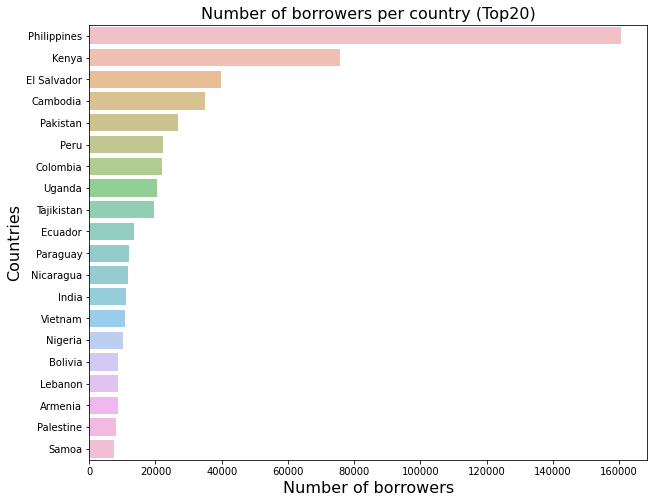

In [ ]:
countries = loan_raw['country'].value_counts()[:20]
plt.figure(figsize=(10,8))
sns.barplot(y=countries.index, x=countries.values, alpha=0.6)
plt.title("Number of borrowers per country (Top20)", fontsize=16)
plt.xlabel("Number of borrowers", fontsize=16)
plt.ylabel("Countries", fontsize=16)
plt.show()

In [ ]:
fig = px.scatter_geo(countries,
                     locationmode="country names",
                     locations=countries.index,
                     hover_name="country", size=countries.values,
                     projection="natural earth")
fig.show()

**Cote D'Ivoire** and **Mauritania** has borrowers who like to borrow more money per request among all countries. Many large-amount requests come from Northern Africa.

Text(0, 0.5, 'Countries')

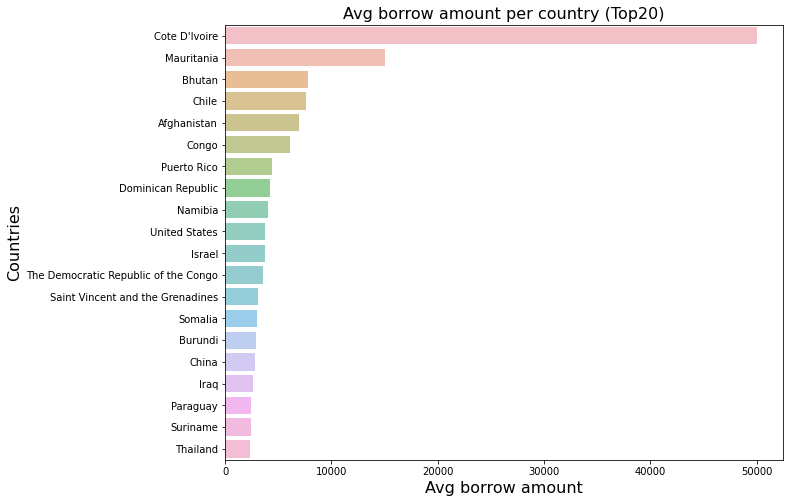

In [ ]:
countries_funded_amount = loan_raw.groupby('country').mean()['funded_amount'].sort_values(ascending = False)
plt.figure(figsize=(10,8))
sns.barplot(y=countries_funded_amount.head(20).index, x=countries_funded_amount.head(20).values, alpha=0.6)
plt.title("Avg borrow amount per country (Top20)", fontsize=16)
plt.xlabel("Avg borrow amount", fontsize=16)
plt.ylabel("Countries", fontsize=16)

In [ ]:
fig = px.scatter_geo(countries_funded_amount,
                     locationmode="country names",
                     locations=countries_funded_amount.index,
                     size=countries_funded_amount.values,
                     projection="natural earth")
fig.show()

In [ ]:
not_funded = loan_raw[loan_raw.isfunded == 0]
funded = loan_raw[loan_raw.isfunded == 1]

**El Salvador** borrowers are most likely not to be funded. Despite most large-amount requests come from Northern Africa, many went unfunded.

In [ ]:
countries = not_funded['country'].value_counts()[:20]
countries[:5]

El Salvador    7152
Kenya          5446
Colombia       3962
Philippines    2834
Uganda         2351
Name: country, dtype: int64

In [ ]:
fig = px.scatter_geo(countries,
                     locationmode="country names",
                     locations=countries.index,
                     size=countries.values,
                     projection="natural earth")
fig.show()

**Philippines** and **Kenya** has the most funded requests among all countries but also because they have the most borrowers.

In [ ]:
countries = funded['country'].value_counts()[:20]
countries[:5]

Philippines    157607
Kenya           70379
Cambodia        33464
El Salvador     32723
Pakistan        24920
Name: country, dtype: int64

In [ ]:
fig = px.scatter_geo(countries,
                     locationmode="country names",
                     locations=countries.index,
                     size=countries.values,
                     projection="natural earth")
fig.show()

## <a id="6">Combine MPI data with Loan Requests</a>

### <a id="61">Data Cleaning</a>

In [ ]:
mpi_region.loc[mpi_region['country'] == 'Viet Nam', 'country'] = 'Vietnam'
mpi_national.loc[mpi_national['country'] == 'Viet Nam', 'country'] = 'Vietnam'
mpi_region.loc[mpi_region['country'] == 'Tanzania, United Republic of', 'country'] = 'Tanzania'
mpi_region.loc[mpi_region['country'] == 'Palestine, State of', 'country'] = 'Palestine'
mpi_national.loc[mpi_national['country'] == 'Palestine, State of', 'country'] = 'Palestine'
mpi_national.loc[mpi_national['country'] == 'Bolivia, Plurinational State of', 'country'] = 'Bolivia'
mpi_region.loc[mpi_region['country'] == 'Congo, Democratic Republic of the', 'country'] = 'The Democratic Republic of the Congo'
mpi_national.loc[mpi_national['country'] == 'Congo, Democratic Republic of the', 'country'] = 'The Democratic Republic of the Congo'
mpi_region.loc[mpi_region['country'] == 'Myanmar', 'country'] = 'Myanmar (Burma)'
mpi_national.loc[mpi_national['country'] == 'Myanmar', 'country'] = 'Myanmar (Burma)'
mpi_region.loc[mpi_region['country'] == 'Côte d\'Ivoire', 'country'] = 'Cote D\'Ivoire'
mpi_national.loc[mpi_national['country'] == 'Côte d\'Ivoire', 'country'] = 'Cote D\'Ivoire'
mpi_region.loc[mpi_region['country'] == 'Lao PDR', 'country'] = 'Lao People\'s Democratic Republic'
mpi_national.loc[mpi_national['country'] == 'Lao PDR', 'country'] = 'Lao People\'s Democratic Republic'

### <a id="62">Join Tables</a>

We first join the regional MPI as regional MPI reflects the exact MPI for where the loan requests coming from.

In [ ]:
# Join loan table with regional data
loan_mpi= loan_raw.merge(mpi_region[['country','region','MPI']], how='left', left_on=['country','region'], right_on=['country','region'])

In [ ]:
loan_mpi['MPI'].isnull().sum(axis=0)/len(loan_mpi)

0.9238174981078778

Since **92%** regional MPI data is still missing, we use national MPI to fill in missing values. We can also get world region too.

In [ ]:
loan_mpi= loan_mpi.merge(mpi_national[['country', 'MPI', 'world_region']], how='left', left_on='country', right_on='country')
loan_mpi['MPI'] = loan_mpi.apply(lambda row: row.MPI_y if np.isnan(row.MPI_x) else row.MPI_x, axis=1)

In [ ]:
loan_mpi['MPI'].isnull().sum(axis=0)/len(loan_mpi)

0.04472708744286387

In [ ]:
loan_mpi[loan_mpi.MPI.isnull()].country.value_counts()

Lebanon                             8792
Samoa                               7396
United States                       6092
Azerbaijan                          1945
Turkey                              1703
Costa Rica                          1561
Kosovo                              1419
Solomon Islands                      554
Panama                               193
Israel                               190
Somalia                               75
Puerto Rico                           68
Saint Vincent and the Grenadines      16
Chile                                 10
Vanuatu                                4
Virgin Islands                         2
Guam                                   1
Name: country, dtype: int64

Now only 4% MPI is missing because OPHI does not have data collected for the countries above.

In [ ]:
loan_mpi.drop(columns=['MPI_y', 'MPI_x'], inplace=True)

Now we fill in the missing world regions for the countries above to find how world region affected a loan being funded or not.

In [ ]:
dict = {'Lebanon':'Europe and Central Asia','United States': 'North America', 'Samoa': 'East Asia and the Pacific', 'Azerbaijan':'Europe and Central Asia', 'Turkey':'Europe and Central Asia', 'Costa Rica':'Latin America and the Caribbean', 'Kosovo':'Europe and Central Asia', 'Solomon Islands':'East Asia and the Pacific', 'Panama':'Latin America and the Caribbean', 'Israel': 'East Asia and the Pacific', 'Somalia':'Sub-Saharan Africa', 'Puerto Rico':'Latin America and the Caribbean', 'Chile':'Latin America and the Caribbean', 'Saint Vincent and the Grenadines': 'Latin America and the Caribbean', 'Vanuatu':'East Asia and the Pacific', 'Virgin Islands':'Latin America and the Caribbean', 'Guam':'East Asia and the Pacific'}
loan_mpi.world_region = loan_mpi.world_region.fillna(loan_mpi.country.map(dict))

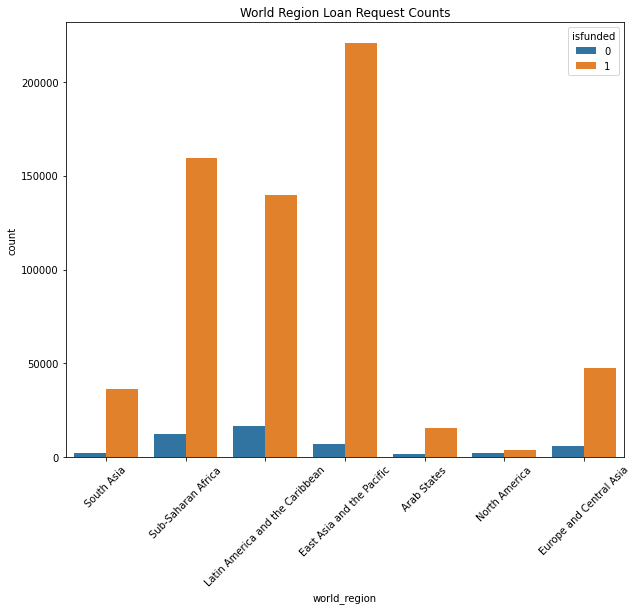

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(x='world_region',hue='isfunded',data=loan_mpi)
plt.title('World Region Loan Request Counts')
plt.xticks(rotation=45)
plt.show()

From the plot above, we can see that **East Asia and the Pacific** has highest chance of getting funds for funding requests.

## <a id="7">Data Pre-Processing</a>

###  <a id="71">Drop Columns</a>
We first drop unrelevant features. This includs **'id', 'tags','disbursed_time','posted_time','funded_time','country_code', 'currency', 'funded_amount', 'lender_count', 'date','disbursed_int', 'funded_int', 'use'**. Note we drop all the time relevant data and funded amount and lender count because in reality we do not know these data until the loan requests is processed on Kiva and receive lenders. We also drop country and currency as they are unique in each country. We also dropped the use column because we have already use NLP to categorize it with common_noun and common_verb.

In [ ]:
loan_mpi.drop(['tags','disbursed_time','posted_time','funded_time','id','country_code', 'currency', 'funded_amount', 'lender_count', 'date','disbursed_int','funded_int'] ,inplace=True,axis=1)

### <a id="72">Fill Missing Values</a>

In [ ]:
missing_loan = loan_mpi.isnull().sum(axis=0)/len(loan_mpi)
missing_loan.sort_values()

loan_amount           0.000000
activity              0.000000
sector                0.000000
country               0.000000
term_in_months        0.000000
repayment_interval    0.000000
isfunded              0.000000
borrower_num          0.000000
common_noun           0.000000
common_verb           0.000000
world_region          0.000000
borrower_genders      0.006289
use                   0.006305
partner_id            0.020122
MPI                   0.044727
region                0.084623
dtype: float64

Fill missing values in **borrower_genders** with 'unknown'


In [ ]:
loan_mpi.borrower_genders.fillna('unknown', inplace=True)

For **partner_id**, we first compute how much loan amount each local field partner has conducted and store them in **partner_count** column

In [ ]:
# Replace partner_id with number of sponsored loan requests, fill with 1 if missing
partner_count = loan_mpi.groupby('partner_id').count()[['loan_amount']]
partner_count = partner_count.rename(columns={'loan_amount':'partner_count'}).reset_index(drop=False)
loan_mpi['partner_count'] = loan_mpi.merge(right=partner_count, how='left',left_on='partner_id', right_on='partner_id')['partner_count']

Then for each missing **partner_id** and **partner_count** we fill with meaningful values. Missing partner_id can be due to the fact that the borrower does not work any local field partner.

In [ ]:
loan_mpi.partner_count = np.where(loan_mpi['partner_id'].isnull,1,loan_mpi.partner_count)
loan_mpi['partner_id'].fillna(-1, inplace=True)

For missing **MPI** we fill with the global mean.

In [ ]:
loan_mpi.MPI = loan_mpi.fillna(np.mean(loan_mpi.MPI))

For missing **region**, we use its respective country as its region.

In [ ]:
loan_mpi['region'].fillna(loan_mpi['country'], inplace=True)

Finally, we drop rows with empty **use** column as our previous NLP technique has categorized it with common verb and common noun.

In [ ]:
loan_mpi.dropna(inplace=True)
loan_mpi.drop('use',inplace=True,axis=1)

In [ ]:
loan_mpi.isfunded.sum()/len(loan_mpi)

0.9258834553825503

Now we have the cleaned version of data to use for modeling and we can see after data cleaning, the percentage of not funded requests is still roughly the same as before.

## <a id="8">Modeling</a>

We are going to use supervised machine learning model here to predict whether a given loan request will be funded. Since there are more loan requests that are funded than not funded, we ware more interested in finding loan requests that are not funded. Instead of using 'isfunded' as our target variable, we will transform this to 'notfunded' so that we can compare model results using f1 score or Jaccard score to find true positives. There are many categorical features which we will use one hot encoding and target encoding for these features. 

In [ ]:
# For time efficency purpose, we saved our cleaned data frame into a local csv file.
loan_mpi = pd.read_csv('clean_loan_mpi.csv')
loan_mpi.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
loan_mpi = loan_mpi.astype({'MPI': 'float64'})
loan_mpi['isfunded'] = loan_mpi['isfunded'].apply(lambda x: 1 if x == 0 else 0)
X = loan_mpi.drop(['isfunded'], axis=1)
y = loan_mpi.isfunded

### <a id="81">Encoding</a>

In [ ]:
X.region.nunique()

12724

Since there are 12724 unique **region**, we cannot use one hot encoding. Otherwise, the datset will be too large. Instead we use **target encoding** for regions.

In [ ]:
encoder = TargetEncoder()
X['region_encoded'] = encoder.fit_transform(X['region'], y)
X.drop('region', axis=1, inplace=True)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Then we **one hot** encode the rest categorical features.

In [ ]:
X = pd.get_dummies(X, columns=['partner_id','activity', 'sector', 'country', 'borrower_genders', 'repayment_interval', 'common_noun', 'common_verb', 'world_region'])

### <a id="82">Train-Test Split</a>
We use 80% of the original data as training data and 20% as testing data. Since our resulting dataset from encoding will be a sparse matrix (contains many 0s), we will use sparse matrix representation for memory efficiency purpose. Specificall we use the [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) representation from Scipy library. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train = csr_matrix(X_train)
X_test = csr_matrix(X_test)

In [ ]:
print("X_train shape is.{}".format(X_train.shape))
print("y_train shape is.{}".format(y_train.shape))
print("X_test shape is.{}".format(X_test.shape))
print("y_test shape is.{}".format(y_test.shape))

X_train shape is.(511378, 667)
y_train shape is.(511378,)
X_test shape is.(127845, 667)
y_test shape is.(127845,)


### <a id="83">Model Training and Tuning</a>

#### <a id="83">Baseline model</a>

We use [decision tree](https://scikit-learn.org/stable/modules/tree.html) with sklearn default hyperparameters as our baseline model since it is the most naive and intuitive ML method for supervised learning. Some drawbacks with decision trees are overfitting and tree construction time.

In [ ]:
# Machine learning training pipeline
def model_pipeline(X_train, y_train, X_test, y_test, model):
    '''    
    X_train: training features with size (n_1,p)
    y_train: training labels with size (n_1,1)
    X_test: testing features with size (n_2, p)
    y_test: testing labels with size (n_2, p)
    
    model: estimator
    
    return: dictionary of performance metrics
    '''
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, predictions)
    precision, recall, threshold = metrics.precision_recall_curve(y_test, predictions)
    f1score = fbeta_score(y_test, predictions, beta=1.0)
    fscore = fbeta_score(y_test, predictions, beta=0.5)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    roc_auc = roc_auc_score(y_test, predictions)
    precision_recall_auc = auc(recall, precision)
    jaccard = jaccard_score(y_test, predictions)
            
    #plot_confusion matrix
    title = type(model).__name__
    disp = plot_confusion_matrix(model, X_test, y_test)                     
    disp.ax_.set_title(title)
    
    performance = {'model':type(model).__name__, 'accuracy': accuracy,
                   'precision': precision, 'recall': recall, 'threshold':threshold,
                   'f1score': f1score, 'fscore':fscore,
                   'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                   'roc_auc': roc_auc, 'precision_recall_auc': precision_recall_auc,
                   'jaccard': jaccard}
    return performance

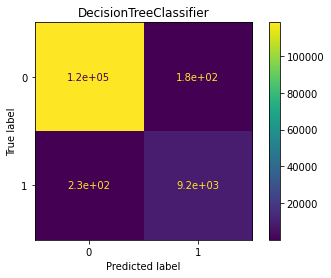

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
baseline_classifier = model_pipeline(X_train, y_train, X_test, y_test, clf)

In [ ]:
baseline_classifier

{'accuracy': 0.996957252923462,
 'f1score': 0.979287577871253,
 'fn': 224,
 'fp': 165,
 'fscore': 0.9811369067941277,
 'jaccard': 0.959415753781951,
 'model': 'DecisionTreeClassifier',
 'precision': array([0.07368298, 0.98237368, 1.        ]),
 'precision_recall_auc': 0.980173303264895,
 'recall': array([1.        , 0.97622081, 0.        ]),
 'roc_auc': 0.9874137599518091,
 'threshold': array([0, 1]),
 'tn': 118260,
 'tp': 9196}

From the confusion matrix above we can see that our decision tree model is doing a pretty good job with 99%+ accuracy and 0.97 f1-score. It makes 4100 wrong classifications (1800 false postives + 2300 false negatives) out of 127845 loan requests. In our case, false positive means we predict a loan request failed even though it will be funded while false negative means we predict a loan request will be funded even thought it will fail. 

#### <a id="831">XGBoost</a>
We use XGBoost (eXtreme Gradient Boosting) as our model because it has been proven useful both in terms of speed and accuracy with binary classification.  XGBoost is an optimized implementation of the Gradient Boosting algorithm. It features (among other enhancements): parallelized tree building, cache-aware access, sparsity awareness, regularization (both L1 and L2), weighted quantile sketch. We can also leverage the GPU power to speed up and plot feature importance with XGBoost.

**Vanilla Model with Default Parameters**



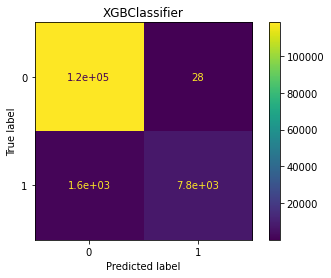

In [ ]:
xgboost_model = XGBClassifier(random_state=RANDOM_STATE, tree_method = "gpu_hist")
performance_xgboost_vanilla = model_pipeline(X_train, y_train, X_test, y_test, xgboost_model)

In [ ]:
performance_xgboost_vanilla

{'accuracy': 0.9874692009855685,
 'f1score': 0.9073667167803864,
 'fn': 1574,
 'fp': 28,
 'fscore': 0.9587936259653925,
 'jaccard': 0.8304403048264183,
 'model': 'XGBClassifier',
 'precision': array([0.07368298, 0.99644399, 1.        ]),
 'precision_recall_auc': 0.9208322407859546,
 'recall': array([1.       , 0.8329087, 0.       ]),
 'roc_auc': 0.9163361341600007,
 'threshold': array([0, 1]),
 'tn': 118397,
 'tp': 7846}

The above confusion matrix shows that we are making total of 1628 errors and 1600 of them are false negative which means we predict the loan request to be funded but they are actually not funded. The accuracy (98%) and f1score (0.9) is lower than our baseline decision tree model which means we need to tune our hyperparametrs to achieve better results.

**Hyperparameter Tuning**

We use 5-fold cross validation to tune our hyperparameters for XGBoost and use standard error loss as our loss function.

In [ ]:
xgboost_model_cv = XGBClassifier(
    tree_method = "gpu_hist",
    random_state=RANDOM_STATE, 
    eval_metric="error"
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [500, 600, 700, 800],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}
# create the Kfold object
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, random_state=RANDOM_STATE)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=xgboost_model_cv, 
    param_distributions=param_grid,
    cv=kfold,
    scoring='neg_log_loss',
    n_jobs=-1,
    n_iter=n_iter,
    refit="neg_log_loss",
)
# fit grid search
best_model = grid.fit(X_train,y_train)
print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

For time efficiency, we trained our model in a different notebook. The output is: Best score: -0.002892152704352265
Best model: 

`{'subsample': 1.0, 'reg_lambda': 1, 'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}`


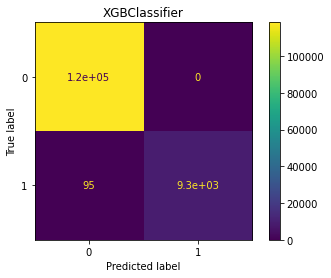

In [ ]:
xgboost_model_best = XGBClassifier(
    tree_method = "gpu_hist",
    random_state=RANDOM_STATE, 
    subsample=1.0,
    reg_lambda=1,
    n_estimators=700,
    max_depth=4,
    learning_rate=0.1,
    gamma=0,
    colsample_bytree=1.0
)
performance_xgboost_best = model_pipeline(X_train, y_train, X_test, y_test, xgboost_model_best)

In [ ]:
performance_xgboost_best

{'accuracy': 0.9992569126676836,
 'f1score': 0.999599063073709,
 'fn': 0,
 'fp': 95,
 'fscore': 0.9993586552012219,
 'jaccard': 0.999198447519406,
 'model': 'XGBClassifier',
 'precision': array([0.99919845, 1.        ]),
 'precision_recall_auc': 0.999599223759703,
 'recall': array([1., 0.]),
 'roc_auc': 0.9949575371549894,
 'threshold': array([1]),
 'tn': 9325,
 'tp': 118425}

As expected, XGBoost performs very well both in time and accuracy. The total hyperparameter search time takes less than 30 minutes and acheived 99.9%+ accuracy and 0.999 f1 score in test data. It only makes 95 wrong classifications way less than the our baseline model which makes 4100 wrong classifications. All the 95 wrong classifications are the result of false negatives which means we predict a loan request will be funded even though it will not be funded.

**Feature Importance**

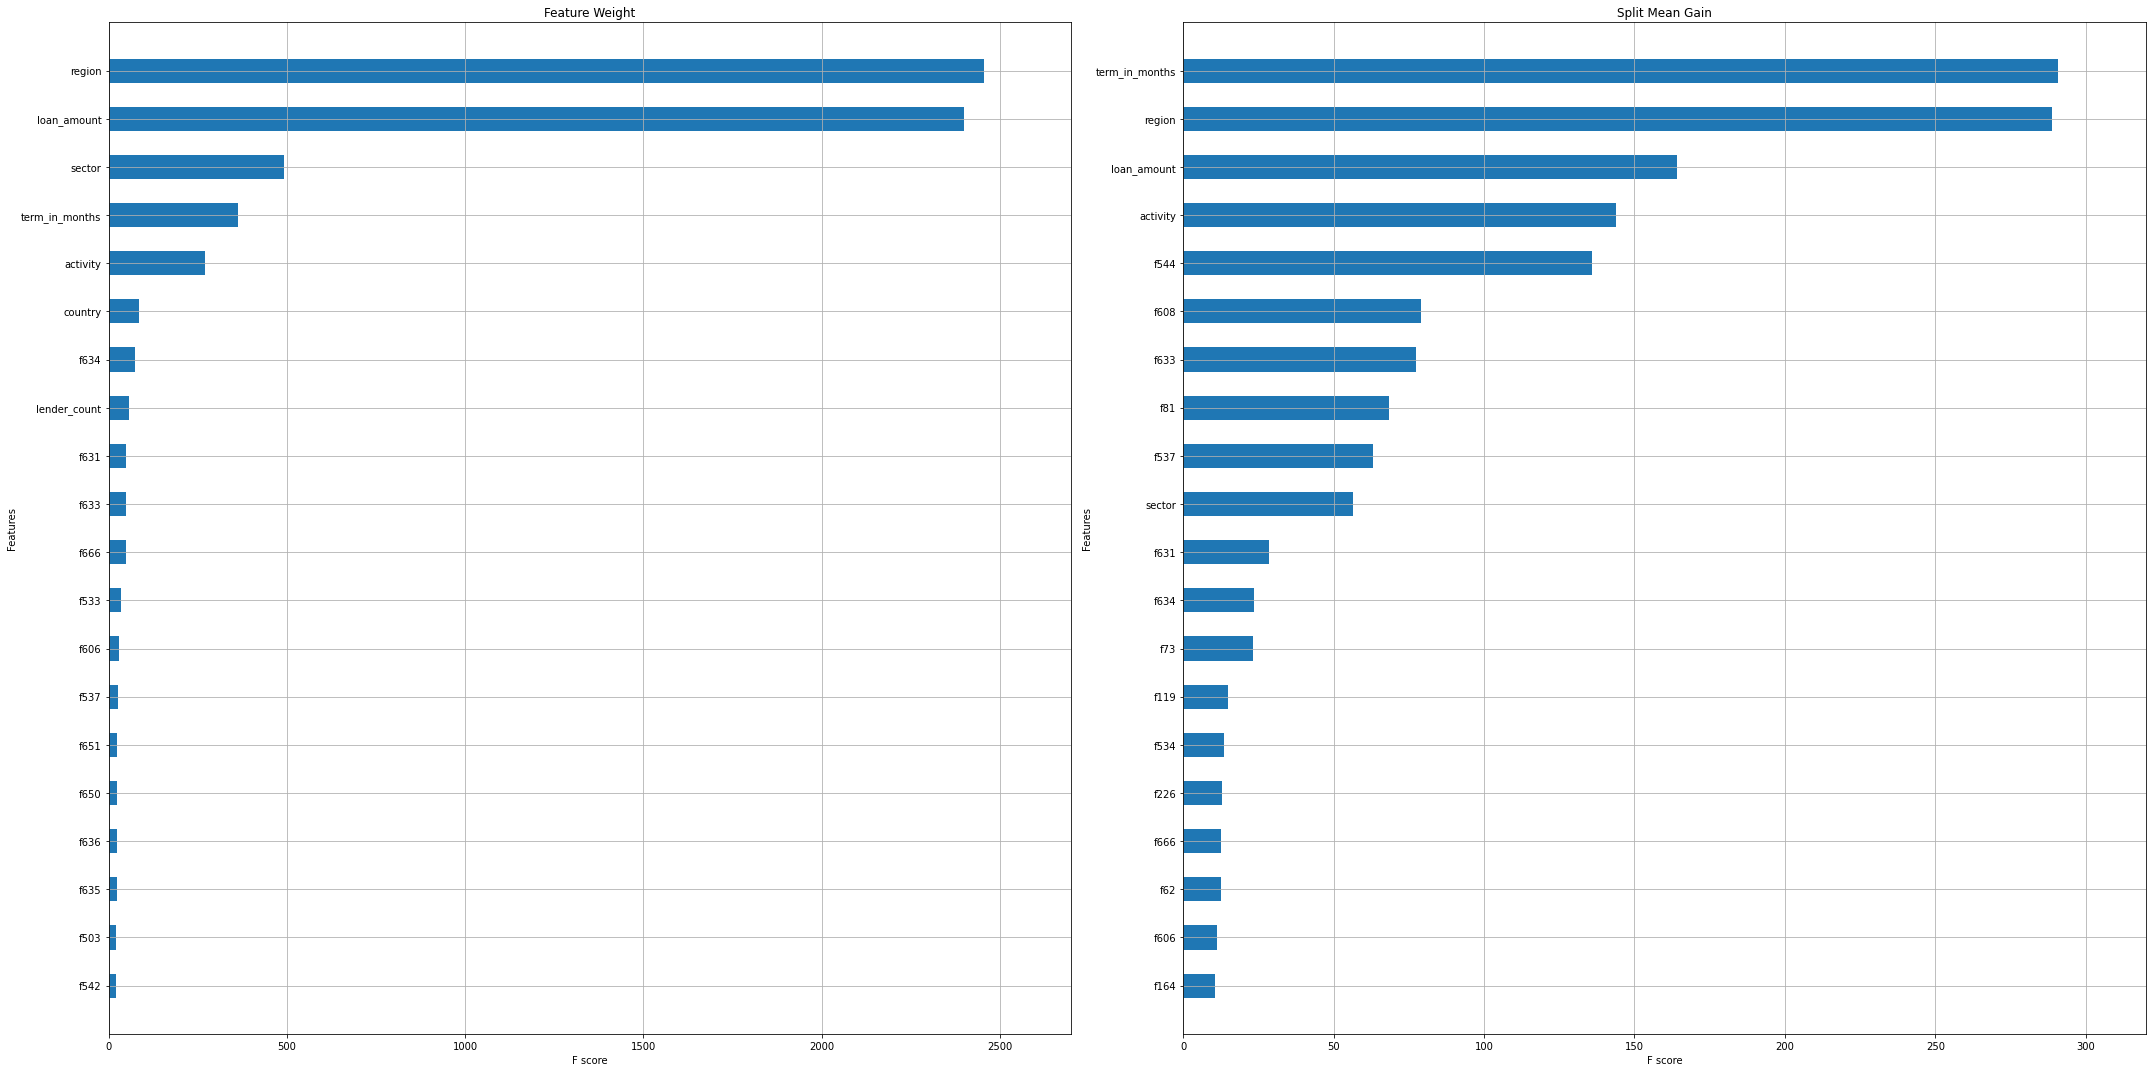

In [ ]:
# saving the feature names to the model
xgboost_model_best.get_booster().feature_names = loan_mpi.drop('isfunded', axis=1).columns.to_list()
# Create the feature importances plot
fig, ax = plt.subplots(1, 2, figsize=(30,15))
# plot importances with feature weight
xgb.plot_importance(
    booster=xgboost_model_best, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
    max_num_features=20
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=xgboost_model_best,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1],
    max_num_features=20
)
plt.tight_layout()
plt.show()

As expected, **region,loan_amount,sector,terms_in_months,country** plays a very important decision rules. When lenders browse projects on Kiva platform, these are the most significant factors they would consider when deciding whether to fund certain projects. **Genders,repayment intervals** are not what lenders consider due to couple possible reasons. First, gender is no longer a deciding factor due to the awarenes of female power. Since most lenders are located in developed countries, they recogonized the power of women and believe in that women can contribute just as much as men. Second, since Kiva is advertised as a non-profit platform, lenders are not too considered about repayment but helping others. Another interesting finding is that 'MPI' feature is not in the top20 deciding factors which will be later discussed in discussion section.

#### <a id="831">AutoML</a>
We use [autoSklearn](https://automl.github.io/auto-sklearn/master/) as our AutoML method to train our dataset. auto-sklearn frees a machine learning user from algorithm selection and hyperparameter tuning. It leverages recent advantages in Bayesian optimization, meta-learning and ensemble construction. It contains 15 classifiers, 14 feature preprocessing methods, and
4 data preprocessing methods, giving rise to a structured hypothesis space with
110 hyperparameters. We set the run time to be 3600 seconds to limit computing power.

[(1.000000, SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'extra_trees', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'select_percentile_classification', 'classifier:extra_trees:bootstrap': 'False', 'classifier:extra_trees:criterion': 'entropy', 'classifier:extra_trees:max_depth': 'None', 'classifier:extra_trees:max_features': 0.34697723213923637, 'classifier:extra_trees:max_leaf_nodes': 'None', 'classifier:extra_trees:min_impurity_decrease': 0.0, 'classifier:extra_trees:min_samples_leaf': 15, 'classifier:extra_trees:min_samples_split': 18, 'classifier:extra_trees:min_weight_fraction_leaf': 0.0, 'data_preproces

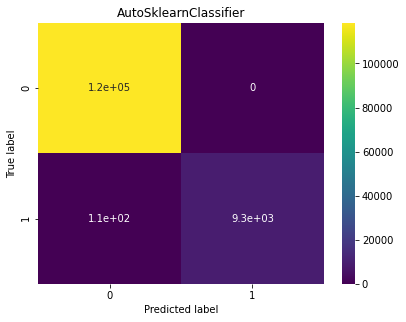

{'model': 'AutoSklearnClassifier', 'accuracy': 0.9991474050608158, 'precision': array([0.07368298, 1.        , 1.        ]), 'recall': array([1.        , 0.98842887, 0.        ]), 'threshold': array([0, 1]), 'f1score': 0.994180769846778, 'fscore': 0.9976641522372706, 'tp': 9311, 'tn': 118425, 'fp': 0, 'fn': 109, 'roc_auc': 0.9942144373673036, 'precision_recall_auc': 0.9946407348368956, 'jaccard': 0.9884288747346072}


In [ ]:
  time=3600
  automl = autosklearn.classification.AutoSklearnClassifier(
      time_left_for_this_task=time,
      per_run_time_limit=int(time/10),
      metric=autosklearn.metrics.log_loss
  )

  automl.fit(X_train, y_train)
  print(automl.show_models())
  predictions = automl.predict(X_test)

  accuracy = metrics.accuracy_score(y_test, predictions)
  precision, recall, threshold = metrics.precision_recall_curve(y_test, predictions)
  f1score = fbeta_score(y_test, predictions, beta=1.0)
  fscore = fbeta_score(y_test, predictions, beta=0.5)
  cm = metrics.confusion_matrix(y_test, predictions)
  tn, fp, fn, tp = cm.ravel()
  roc_auc = roc_auc_score(y_test, predictions)
  precision_recall_auc = auc(recall, precision)
  jaccard = jaccard_score(y_test, predictions)
          
  # plot_confusion matrix
  title = type(automl).__name__
  plt.figure(figsize=(6.4, 4.8))
  sns.heatmap(cm, annot=True, cmap='viridis')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title(title)
  plt.show()
  
  performance = {'model':type(automl).__name__, 'accuracy': accuracy,
                  'precision': precision, 'recall': recall, 'threshold':threshold,
                  'f1score': f1score, 'fscore':fscore,
                  'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                  'roc_auc': roc_auc, 'precision_recall_auc': precision_recall_auc,
                  'jaccard': jaccard}
  print(performance)

AutoML performs better than baseline model but a bit worse than XGBoost. AutoML achieves 99.9% accuracy and 0.997 f1 score and makes 1100 wrong classifications. All the 1100 wrong classifications are the result of false negatives which means we predict a loan request will be funded even though it will not be funded. AutoML also suggests that an ensamble method of different tree based methods(Simple Classification Pipeline which consists of Decision Tree, adaboost, random_forest etc.) is most suitable for this supervised learning problem

## <a id="9">Discussion</a>
We initially did not use the **region** column to train our model since the number of unique regions is too large to use one hot encoding and it would cause memory errors. Since we believe MPI data can provide some insight to regions, we hope to see MPI reflect regional data. As it turns out, without region column, we still get very good results in prediction with XGBoost, and MPI, indeed, provides a very high feature importance and split mean gain. 

However, with target encoding, 'region' becomes a more important feature and 'MPI' feature is barely used during XGBoost.

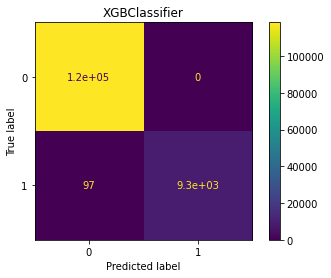

In [ ]:
xgboost_model_best = XGBClassifier(
    tree_method = "gpu_hist",
    random_state=RANDOM_STATE, 
    subsample=1.0,
    reg_lambda=1,
    n_estimators=700,
    max_depth=4,
    learning_rate=0.1,
    gamma=0,
    colsample_bytree=1.0
)
performance_xgboost_best = model_pipeline(X_train, y_train, X_test, y_test, xgboost_model_best)

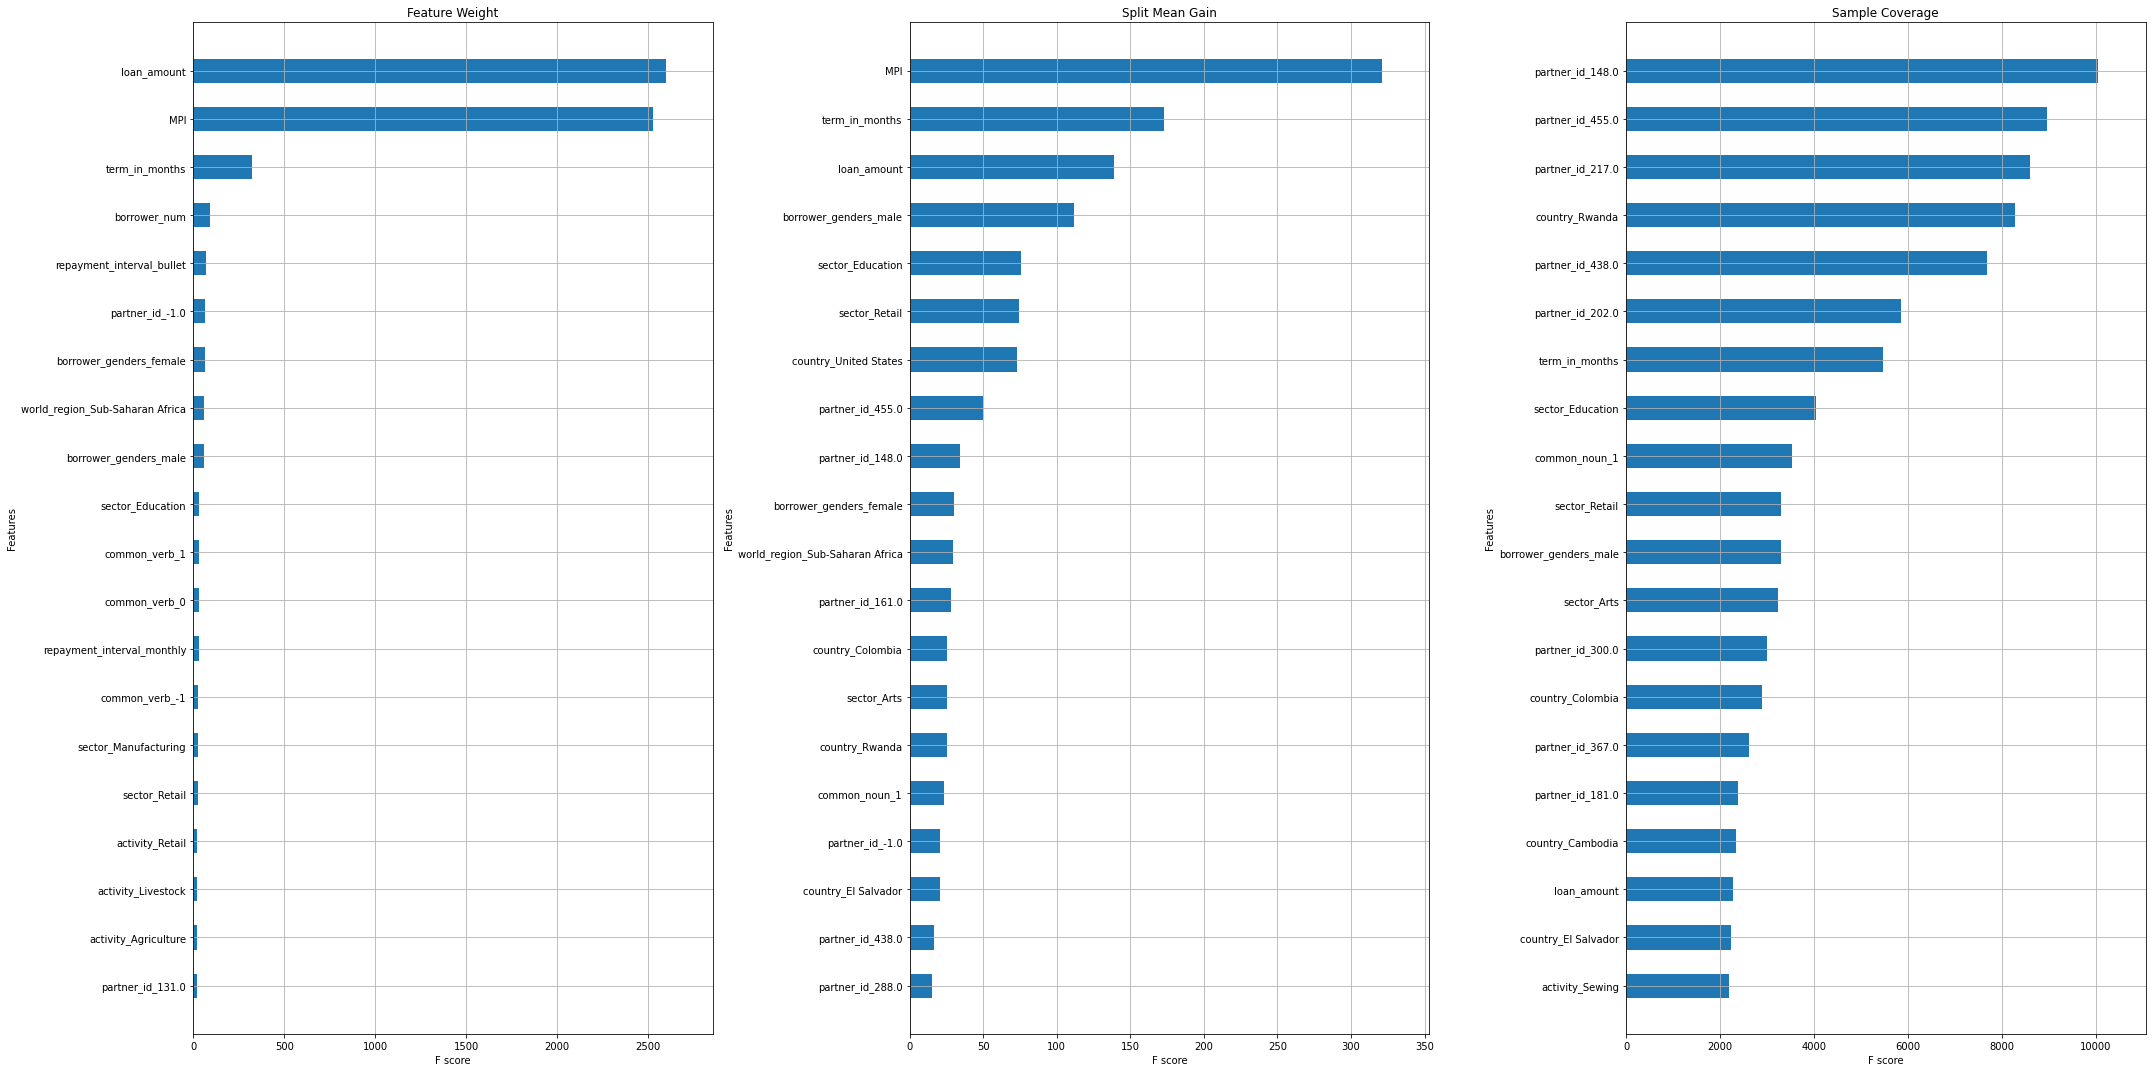

In [ ]:
xgc = xgboost_model_best
# saving the feature names to the model
xgc.get_booster().feature_names = clean_mpi.drop('isfunded', axis=1).columns.to_list()
# Create the feature importances plot
fig, ax = plt.subplots(1, 3, figsize=(30,15))
# plot importances with feature weight
xgb.plot_importance(
    booster=xgc, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
    max_num_features=20
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=xgc,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1],
    max_num_features=20
)
# plot importances with sample coverage
xgb.plot_importance(
    xgc,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2],
    max_num_features=20
)
plt.tight_layout()
plt.show()

## Conclusion

### Feature preparation
We collected raw datset from [Kaggle]( https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding) and [MPI](https://ophi.org.uk/multidimensional-poverty-index/). 
* We transformed time data from timestamp to intervals
* With string manipulation, we extracted *borrower_count* out of *borrower_gender*, and mapped borrowers into 4 gender-based categories {‘female’, ‘male’, ‘group’, ‘others’}
* Using nltk tokenizer, we pre-processed text data in *use*. We retrieved the most common verbs, nouns in loan transaction descriptions, and visualized them using WordCloud. We extracted the top 10 most frequent verbs and nouns, and mapped the original *use* column into *common_noun* and *common_verb*; if the original *use* contains 1 of the top 10 most frequently appearing words, it is labeled as the word, otherwise labeled as ‘others’
* We used plotly.scatter_geo to visualize geographical data
* For missing values: 
  * We used mean replacement for NaN in ‘MPI’
  * We replaced NaN in ‘region’ with ‘country_name’
  * We labeled records as an independent category in ‘partner_id’, ‘gender’ because data can be missing for a reason.

### Data analytics
Some key observations we made from our EDA:
- Both *Funded Loan Amount* and *Requested Loan Amount* are highly left skewed. 
- After log-transformation, we observed *Funded Loan Amount* has slightly higher quantiles and more outliers in the higher range.
- Activities like Food Product/Sales, Pigs, Higher Education Cost and Home Appliances have a higher amount of unfunded requests
- Sectors like Food, Services, Personal Use has a higher portion of unfunded loans compared with the others
- Most of loans (83.6%) are requested by a single borrower. 63.9% borrowers are female, 20.2% are male.
- Monthly paid loans have a higher proportion of not funded requests.
-  The top 3 commonly used nouns in loan-request description are ‘business’, ‘water’, ‘supplies’
-  The top 3 commonly used verbs in loan-request description are ‘buy’, ‘purchase’, 'sell'

### Model comparison
Out of our three models (decision tree/ XGBoost/ autoML), we find out that all of them achieves very good results in terms of accuracy (99%+) because our original dataset is very skewed (92% loan requests are funded). In terms of f1 score, which captures the minority classes in our dataset, XGBoost and autoML have better f1 scores than baseline model, while XGBoost performs a bit better and making less errors.
### Model intepretation
As autoML suggests, simple classification method (tree based) are most suitable for this data set and XGboost, which makes the smallest testing errors, confirms this observation. 

In addition, XGBoost finds out the most important features among all features. These includes **region,loan_amount,sector,terms_in_months,country**, while **Genders,repayment intervals** are not considered important.


**MPI** and **region** are features that correlate with each other. one suggestion to Kiva platform is that Kiva should add MPI index to each loan request based on the geolocation to help lenders better identify which loan request to fund. (Often times a foreign region name does not stand out in lenders' eyes but a MPI number is more reflective of that region)
### Future work
We used target encoding on *region* for dimension reduction. Despite the tuned XGBoost arrived a very pleasant f1-score(more than 99%), using target encoding may not be the best option for us given it uses the averaged response variable, in our case a binary variable, to replace categorical data. If given more time and computational power, we will use one-hot encoding to integrate **region** into our model. 

Prediction result from AutoML does not explicitly identifies which model contributes the most within the ensemble model. Instead, we arrived at a 100% SimpleClassifierPipeline, which is a combination of Adaboost, Decision Tree, Gradient Boosting, SVC, Random Forest, Gaussian Mixture and Decision Tree. If time permits, we can further improve our model by manually trying an ensemble model consisted of multiple classification models. Based on the result we have, we can make an educated guess that Adaboost may serve as the most heavily weighted model.